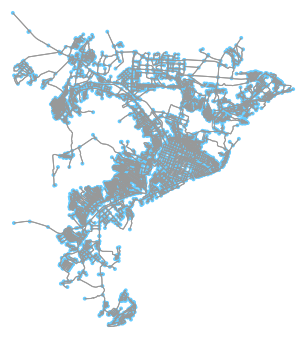

In [3]:
import osmnx as ox
import networkx as nx
from pprint import pprint
import numpy as np
import math
from random import random
import matplotlib.pyplot as plt
import osmapi as osm

#Api по id получить координаты и другую инфн
api = osm.OsmApi()
#no = api.NodeGet(6567460866)

place = {'city' : 'Saratov',
         'country' : 'Russia'}
G = ox.graph_from_place(place, network_type='drive')

#Рисуем граф дорог
fig, ax = ox.plot_graph(G)

In [4]:
#Словарь расстояний между смежными перекрестками
a = G.adj
dictionary = {}
dict_name = {}

for key, value in a.items():
    for key_a, value_a in value.items():
        if key in dictionary:
            dictionary[key].append({key_a : value_a[0]['length']})
        else:
            dictionary[key] = [{key_a : value_a[0]['length']}]

nodes_list = list(G.nodes())

In [10]:
#Достаем все здания
buildings = ox.footprints.footprints_from_place(place, footprint_type='building', retain_invalid=False, which_result=1)

#Из первых 10000 выбираем 10 больниц и 100 домов
hospital = []
apartments = []
n = 10000
build = buildings.head(n)['building'].to_dict()

for key, value in build.items():
    if value == 'hospital':
        hospital.append(key)
    elif value == 'apartments':
        apartments.append(key)

hospitals = hospital[:3]
apartments = apartments[:10]

print(hospital)
print(apartments)


[86350946, 86350950, 86350953, 86351386, 86351393, 86968075, 87065291, 87183858, 87183860, 90944648, 90944650, 90944666, 90944690, 90944692, 91640238, 91640250, 91640264, 91640299, 92969088, 103132550]
[30963271, 36073665, 36073669, 36073671, 36073678, 36073680, 36073681, 36073682, 36073683, 36073684]


In [11]:
#Находим ближайшие узлы до домов и больниц
a = buildings.head(n).to_dict()
hospitals_dict = {}
apartments_dict = {}

print('Больницы')
for i in hospitals:
    bounds = a['geometry'][i].bounds
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    hospitals_dict[i] = nearest_node
    print(i, nearest_node)
print('------------------')
print('Апартаменты')
for i in apartments:
    bounds = a['geometry'][i].bounds
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    apartments_dict[i] = nearest_node
    print(i, nearest_node)


Больницы
86350946 349310231
86350950 349310231
86350953 341817337
------------------
Апартаменты
30963271 5223770088
36073665 421435856
36073669 421435796
36073671 421440571
36073678 358415134
36073680 421498795
36073681 421498795
36073682 421498795
36073683 421461663
36073684 421498773


In [12]:
#Матрица смежности графа
G_pd = nx.to_pandas_adjacency(G)
G_pd = G_pd.values
G_size = len(G_pd)
INF = 10**10

#Заполнение матрицы смежности с учетом условий взвешенного расстояния
for i in range(G_size):
    for j in range(G_size):
        if G_pd[i][j] == 1:
            for k in range(len(dictionary[nodes_list[i]])):
                if nodes_list[j] in dictionary[nodes_list[i]][k].keys():
                    distance = dictionary[nodes_list[i]][k][nodes_list[j]]

            weight = 1
            if nodes_list[i] in hospitals_dict.values():
                weight = random() + 1

            G_pd[i][j] = distance * weight

        elif G_pd[i][j] == 0:
            G_pd[i][j] = INF

#Создаем словарь {id узла}: {его index в списке узлов}
nodes_numbers = {}
for index,i in enumerate(nodes_list):
    nodes_numbers[i]=index

In [13]:
#Алгоритм Дейкстры
def Dijkstra(N, S, matrix):
    valid = [True]*N
    weight = [INF]*N
    p = [INF] * N
    weight[S] = 0
    for i in range(N):
        min_weight = INF + 1
        ID_min_weight = -1
        for j in range(N):
            if valid[j] and weight[j] < min_weight:
                min_weight = weight[j]
                ID_min_weight = j
        for z in range(N):
            if weight[ID_min_weight] + matrix[ID_min_weight][z] < weight[z]:
                weight[z] = weight[ID_min_weight] + matrix[ID_min_weight][z]
                p[z] = ID_min_weight
        valid[ID_min_weight] = False
    return weight, p

In [15]:
#1

#Для каждого узла(дома) запускаем алгоритм Д.
from_apartments = {}
from_hospitals = {}
from_apartments_p = {}
from_hospitals_p = {}
for key, value in apartments_dict.items():
    start = nodes_numbers[value]
    weight, p = Dijkstra(G_size, start, G_pd)

    from_apartments[key] = weight
    from_apartments_p[key] = p
    
#Для каждого узла(больници) запускаем алгоритм Д.
for key, value in hospitals_dict.items():
    start = nodes_numbers[value]
    weight, p = Dijkstra(G_size, start, G_pd)

    from_hospitals[key] = weight
    from_hospitals_p[key] = p

X = 5000
object_there = {}
object_back = {}
object_there_back = {}

In [16]:
#Вычисляем от каждого узла(дома) расстояние до ближайшей больници
for key_from, value_from in from_apartments.items():
    min_weight = INF
    min_index = -1
    weight_size = len(value_from)

    node_from = apartments_dict[key_from]
    index_from = nodes_numbers[node_from]

    for key_to, value_to in from_hospitals.items():
        node_to = hospitals_dict[key_to]
        index_to = nodes_numbers[node_to]

        #1a
        if value_from[index_to] < min_weight:
            min_weight = value_from[index_to]
            min_index = key_to

        #1b
        if value_from[index_to] < X:
            if key_from in object_there:
                object_there.append(key_to)
            else:
                object_there[key_from] = [key_to]

    print("min lenght from ", key_from, " to ", min_index, " is ", min_weight)

min lenght from  30963271  to  86350953  is  10336.231
min lenght from  36073665  to  86350953  is  10151.840999999999
min lenght from  36073669  to  86350953  is  9911.162999999999
min lenght from  36073671  to  86350953  is  9658.064
min lenght from  36073678  to  86350953  is  9344.757
min lenght from  36073680  to  86350953  is  9479.399
min lenght from  36073681  to  86350953  is  9479.399
min lenght from  36073682  to  86350953  is  9479.399
min lenght from  36073683  to  86350953  is  9201.984000000002
min lenght from  36073684  to  86350953  is  9176.909000000001


In [17]:
#Вычисляем от каждого узла(больницы) расстояние до ближайшего дома
mi_to = INF
mi_index_to = -1
for key_from, value_from in from_hospitals.items():
    min_weight = INF
    min_index = -1
    weight_size = len(value_from)

    node_from = hospitals_dict[key_from]
    index_from = nodes_numbers[node_from]

    for key_to, value_to in from_apartments.items():
        node_to = apartments_dict[key_to]
        index_to = nodes_numbers[node_to]

        #1a
        if value_from[index_to] < min_weight:
            min_weight = value_from[index_to]
            min_index = key_to

        #1b
        if value_from[index_to] < X:
            if key_from in object_back:
                object_back.append(key_to)
            else:
                object_back[key_from] = [key_to]

    print("min lenght from ", key_from, " to ", min_index, " is ", min_weight)

min lenght from  86350946  to  36073684  is  9712.547585827342
min lenght from  86350950  to  36073684  is  9712.547585827342
min lenght from  86350953  to  36073684  is  9380.107435966938


In [18]:
#Находим больницу расстояние до которой и обратно минимально
for key_from, value_from in from_apartments.items():
    node_from = apartments_dict[key_from]
    index_from = nodes_numbers[node_from]

    min_path = INF
    min_index = -1
    for key_to, value_to in from_hospitals.items():
        node_to = hospitals_dict[key_to]
        index_to = nodes_numbers[node_to]

        w = value_from[index_to] + value_to[index_from]

        #1a
        if w < min_path:
            min_path = w
            min_index = key_to

        #1b
        if value_from[index_to] < X:
            if key_from in object_there_back:
                object_there_back.append(key_to)
            else:
                object_there_back[key_from] = [key_to]

    print("min path from ", key_from, " to ", min_index, " is ", min_path)


min path from  30963271  to  86350953  is  20661.7539665007
min path from  36073665  to  86350953  is  20506.880435966938
min path from  36073669  to  86350953  is  20025.524435966938
min path from  36073671  to  86350953  is  19519.32643596694
min path from  36073678  to  86350953  is  18739.55543596694
min path from  36073680  to  86350953  is  19206.52543596694
min path from  36073681  to  86350953  is  19206.52543596694
min path from  36073682  to  86350953  is  19206.52543596694
min path from  36073683  to  86350953  is  18651.69543596694
min path from  36073684  to  86350953  is  18557.01643596694


In [27]:
#2.2
#Вычисляем от каждого узла(больницы) расстояние до ближайшего дома
weight_min_there = INF
weight_min_back = INF
weight_min_there_back = INF
index_min_there = -1
index_min_back = -1
index_min_there_back = -1

for key_from, value_from in from_hospitals.items():
    node_from = hospitals_dict[key_from]
    index_from = nodes_numbers[node_from]

    weight_there = 0
    weight_back = 0
    weight_there_back = 0
    index_there = -1
    index_back = -1
    index_there_back = -1

    for key_to, value_to in from_apartments.items():
        node_to = apartments_dict[key_to]
        index_to = nodes_numbers[node_to]

        if value_to[index_from] > weight_there:
            weight_there = value_to[index_from]
            index_there = key_from

        if value_from[index_to] > weight_back:
            weight_back = value_from[index_to]
            index_back = key_from

        w = value_to[index_from] + value_from[index_to]

        if w > weight_there_back:
            weight_there_back = w
            index_there_back = key_from

    if weight_there < weight_min_there:
        weight_min_there = weight_there
        index_min_there = index_there
    
    if weight_back < weight_min_back:
        weight_min_back = weight_back
        index_min_back = index_back

    if weight_there_back < weight_min_there_back:
        weight_min_there_back = weight_there_back
        index_min_there_back = index_there_back

print("there: ", index_min_there, weight_min_there)
print("back: ", index_min_back, weight_min_back)
print("there and back: ", index_min_there_back, weight_there_back)


there:  86350953 10336.231
back:  86350953 10355.039435966939
there and back:  86350953 20661.7539665007


In [28]:
#2.3
#Больница до которой сумма расстояний до всех домов из выборки минимальна
min_s = INF
min_index = -1
for key_from, value_from in from_hospitals.items():
    node_from = hospitals_dict[key_from]
    index_from = nodes_numbers[node_from]

    s = 0

    for key_to, value_to in from_apartments.items():
        node_to = apartments_dict[key_to]
        index_to = nodes_numbers[node_to]

        s += value_from[index_to]

    if s < min_s:
        min_s = s
        min_index = key_from

print("min sum: ", key_from, min_s)


min sum:  86350953 98062.18289020316


In [35]:
#2.4
#Дерево кратчайших путей минимально
s_min = INF
index_min = -1
for key_from, value_from in from_hospitals_p.items():
    node_from = hospitals_dict[key_from]
    index_from = nodes_numbers[node_from]

    s = 0

    used = [0] * G_size

    for key_to, value_to in from_apartments.items():
        node_to = apartments_dict[key_to]
        index_to = nodes_numbers[node_to]

        v = index_to
        start = index_from
        while v != start:
            if used[v] == 0:
                used[v] = 1
                s += G_pd[value_from[v]][v]
            v = value_from[v]

    if s < s_min:
        s_min = s
        index_min = key_from

print("min tree: ", index_min, s_min)

min tree:  86350953 21356.01340246766
